## ABOUT
__Author__: Pat McCornack

__Date__: 2/28/24

__Purpose__: Evaluate F40 model results.

----

In [45]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

import rasterio
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [46]:
local_root_dir = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40_modeling"
pnnl_root_dir = r"\\pnl\projects\BPAWildfire\data\Landfire\fuels_modeling\F40_modeling"

# Define which root directory to work off of
active_root_dir = pnnl_root_dir

# Define filepaths
paths_dict = {
    'ref_data_dir' : os.path.join(active_root_dir, "LF_raster_data/_tables"),  # LF csv tables - used by read_ref_data
    'model_output_dir' : os.path.join(active_root_dir, "model_outputs"),  # Where predictions are saved
    'predictions_fname' : r"F40_model_results_2024-05-09_08-57-34\Predictions_LF22_F40_HGBC.csv",
    
    # Raster assessment
    'pred_F40_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_F40_Pred_2024-05-10_11-34-22.tif"),
    'og_F40_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_F40_230_bpa.tif"),
    'results_out_dir' : os.path.join(active_root_dir, r"model_outputs\tabular"),
    'results_out_fname' : 'raster_results_LF22_F40_Pred_2024-05-10_11-34-22.csv'
 }

# __Functions__

----

## __Visualizations__

### __Plot the Class Distribution__
Plots the distribution of the variable of interest. Can be set to display the raw counts for each class or the percentage of the dataste that the class accounts for. 

In [47]:
def plot_distribution(df, group_var, metric='Count', sort=True, title=f'Distribution', figsize=(15, 50)):
    """
    Plots the distribution of group_var. 'metric' can be set to either 'Count' or 'Percent' to change the display type. 
    The 'sort' argument specifies whether to sort the display in order from most common to least common. 
    """
    # Get count of target class
    df_gp = df.groupby(group_var).count().reset_index()
    df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

    # Get classes proportional representation
    df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
    df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str
    if sort == True: 
        df_gp = df_gp.sort_values(by="Count", ascending=True)

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    hbars = ax.barh(df_gp[group_var],
                df_gp[metric],
                align='center')
    ax.set(title=title,
        xlabel= f'{metric}', 
        ylabel=f'{group_var}')  
    ax.bar_label(hbars, fmt=" %.2f")
    
    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y(), ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

### __Compare the Distribution of the Misclasses vs. Actual__
Plot a graph to see how the distribution of the misclasses compares with the distribution of the true classes. Metric can be set to 'Count' for raw counts or 'Percent'. If metric='Percent', then the 'total' value represents the percent representation of that class in the original dataset (e.g. Tr Northern Rocky Mountain Dry-Mesic Montane Mixed Conifer Forest accounts for 7.47% of observations in the true dataset), and the 'Misclass' value is the percent proportion of the misclassification data (e.g. Tr Northern Rocky Mountain Dry-Mesic Montane Mixed Conifer Forest accounts for 9.91% of all misclassed observations).

In [48]:
def plot_comparison_distribution(df_dict, group_var, metric='Count', sort=True, title=f'Distribution', figsize=(15, 50)):
    """
    Plots distributions of the true vs. misclassed datasets.

    Arguments:
    df_dict: Dictionary with the keys 'total' and 'misclass'. The corresponding values should be dataframes, where the 'total'
    dataframe is the original predictions subset to only include target classes found in the 'misclass' set and the 'misclass' dataframe
    is the original predictions subset to observations where the predicted target value does not match the actual. 

    metric = 'Count' / 'Percent' : Changes how to view the data - by raw counts or by proportions. 

    sort = True/False : Choose whether to sort the data before displaying it. 
    """
    
    df_gp_dict = {}
    
    # Aggregate the data
    for key, df in df_dict.items():
        # Get count of target class
        df_gp = df.groupby(group_var).count().reset_index()
        df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

        # Get classes proportional representation
        df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
        df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str

        df_gp_dict[key] = df_gp

    # sort values before plotting
    if sort == True:
        df_gp_dict['misclass'] = df_gp_dict['misclass'].sort_values(by=metric)
        df_gp_dict['total'] = df_gp_dict['total'].reindex(df_gp_dict['misclass'].index)

    # Set up to plot side-by-side
    ind = np.arange(len(df_gp_dict['misclass'])) # The y locations for groups
    width = 0.4

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    total_bar = ax.barh(ind+width/2, df_gp_dict['total'][metric], width, label='Total')
    misclass_bar = ax.barh(ind-width/2, df_gp_dict['misclass'][metric], width, label='Misclass')

    ax.set_title(title)
    ax.set_xlabel(f'{metric}')
    ax.set_yticks(ind)
    ax.set_yticklabels(df_gp_dict['misclass'][group_var].values)
    ax.legend(loc='right')
    ax.bar_label(total_bar, fmt=" %.2f")
    ax.bar_label(misclass_bar, fmt=" %.2f")

    # Remove whitespace at margins
    #plt.ylim(ax.patches[0].get_y()-0.5, ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

### __Assess the Proportion of the Actual Values that were Misclasses__
Create a plot to display the percentage of each class that was misclassified alongside that classes total representation in the dataset. Setting the 'metric' argument will only affect how the total representation is displayed - by 'Count' or 'Percent' - the misclassified proportion will not change. 

In [49]:
# Plots the percent of the total class the misclass count is
def plot_percent_total(df_dict, group_var, sort=True, title=f'Distribution', metric='Count', figsize=(15, 50)):
    """
    Plots the proportion of each class that was misclassified, alongside its total representation in the dataset. 

    Arguments:
    df_dict: Dictionary with the keys 'total' and 'misclass'. The corresponding values should be dataframes, where the 'total'
    dataframe is the original predictions subset to only include target classes found in the 'misclass' set and the 'misclass' dataframe
    is the original predictions subset to observations where the predicted target value does not match the actual. 

    metric = 'Count' / 'Percent' : Changes how to view the data - by raw counts or by proportions. 

    sort = True/False : Choose whether to sort the data before displaying it. 
    """
    
    df_gp_dict = {}
    
    # Aggregate the data
    for key, df in df_dict.items():
        # Get count of target class
        df_gp = df.groupby(group_var).count().reset_index()
        df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

        # Get classes proportional representation
        df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
        df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str

        df_gp_dict[key] = df_gp

    # Calculate percent of total 
    total_perc = df_gp_dict['misclass']['Count'] / df_gp_dict['total']['Count'] * 100

    # Sort the data before plotting
    if sort == True:
        total_perc = total_perc.sort_values()
        df_gp_dict['total'] = df_gp_dict['total'].reindex(total_perc.index)

    # Set up to plot side-by-side
    ind = np.arange(len(total_perc)) # The y locations for groups
    width = 0.4

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    total_count_bar = ax.barh(ind-width/2, df_gp_dict['total'][metric], width, label=f'Total {metric}')
    total_perc_bar = ax.barh(ind+width/2, total_perc, width, label='Misclass Percent')
  
    ax.set_title(title)
    ax.set_xlabel('Percent')
    ax.set_yticks(ind)
    ax.set_yticklabels(df_gp_dict['total'][group_var].values)
    ax.legend(loc='right')
    ax.bar_label(total_perc_bar, fmt=" %.2f")
    ax.bar_label(total_count_bar, fmt=f" %.2f")

    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y()-0.5, ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

## __Data Processing__

### __Create Data Dictionaries to Append Features__
Some features are separate attributes of the LANDFIRE dataset (e.g. BPS Fire Regime) and others are useful for results analysis (e.g. FDst attributes). These can be mapped to points using LANDFIRE CSVs. The below creates dictionaries to perform that mapping. 

This function is called by join_features.

In [50]:
def read_ref_data(ref_data_dir=paths_dict['ref_data_dir']):
    """
    Returns a dictionary of dictionaries of mappings between LANDFIRE raster values and other attributes associated with those values. 
    """
    data_dir = ref_data_dir
    LF22_FVT_fname = "LF22_FVT_230.csv"
    LF22_FVC_fname = "LF22_FVC_230.csv"
    LF22_FVH_fname = "LF22_FVH_230.csv"
    LF22_FDST_fname = "LF22_FDST_230.csv"
    
    # Create empty dictionary
    LF_ref_dicts = {}

    # Join fuel type names from values
    LF22_FVT_df = pd.read_csv(os.path.join(data_dir, LF22_FVT_fname))
    LF_ref_dicts['Original_FVT_NAME'] = dict(LF22_FVT_df[['VALUE', 'EVT_FUEL_N']].values)
    LF_ref_dicts['Predicted_FVT_NAME'] = dict(LF22_FVT_df[['VALUE', 'EVT_FUEL_N']].values)
   
    # Join fuel cover names from values
    LF22_FVC_df = pd.read_csv(os.path.join(data_dir, LF22_FVC_fname))
    LF_ref_dicts['Original_FVC_NAME'] = dict(LF22_FVC_df[['VALUE', 'CLASSNAMES']].values)
    LF_ref_dicts['Predicted_FVC_NAME'] = dict(LF22_FVC_df[['VALUE', 'CLASSNAMES']].values)

    # Join fuel height names from values
    LF22_FVH_df = pd.read_csv(os.path.join(data_dir, LF22_FVH_fname))
    LF_ref_dicts['Original_FVH_NAME'] = dict(LF22_FVH_df[['VALUE', 'CLASSNAMES']].values)
    LF_ref_dicts['Predicted_FVH_NAME'] = dict(LF22_FVH_df[['VALUE', 'CLASSNAMES']].values)

    # Join FDST attributes from values
    LF22_FDST_df = pd.read_csv(os.path.join(data_dir, LF22_FDST_fname))
    LF_ref_dicts['FDST_TYPE'] = dict(LF22_FDST_df[['VALUE', 'D_TYPE']].values)
    LF_ref_dicts['FDST_SEV'] = dict(LF22_FDST_df[['VALUE', 'D_SEVERITY']].values)    
    LF_ref_dicts['FDST_TSD'] = dict(LF22_FDST_df[['VALUE', 'D_TIME']].values)
    
    return LF_ref_dicts
                         
        

### __Append Features using Data Dictionaries__
Append in selected features using the LANDFIRE data dictionaries.

__Note:__ Items in feature_list must be in the source_layers dictionary. 

In [51]:
def create_features(df, feature_list = ['FDST_TYPE', 'FDST_SEV', 'FDST_TSD']):
    """
    Returns the sample_points layer with the features in feature_list appended. 

    Items in feature_list must be in the source_layers dictionary.  
    """
    # Get names associated with FVT values
    LF_ref_dicts = read_ref_data()
    
    # Define which LANDFIRE layer each new feature maps to
    source_layers = {
        'Original_FVT_NAME' : 'LF22_FVT', 
        'Predicted_FVT_NAME' : 'Predicted_LF22_FVT',
        'Original_FVC_NAME' : 'LF22_FVC', 
        'Predicted_FVC_NAME' : 'Predicted_LF22_FVC',
        'Original_FVH_NAME' : 'LF22_FVH', 
        'Predicted_FVH_NAME' : 'Predicted_LF22_FVH',
        'FDST_TYPE' : 'LF22_FDST',
        'FDST_SEV' : 'LF22_FDST',
        'FDST_TSD' : 'LF22_FDST'
    }

    # Create the feature
    for feature in feature_list:
        df[feature] = df[source_layers[feature]].map(LF_ref_dicts[feature]).copy()

    # Get Prefix Code -- used to asses ecological similarity
    if feature_list == ['Original_FVT_NAME', 'Predicted_FVT_NAME']:
        df['Original_FVT_Prefix'] = df['Original_FVT_NAME'].str.split(" ", expand=True)[0]
        df['Predicted_FVT_Prefix'] = df['Predicted_FVT_NAME'].str.split(" ",expand=True)[0]
    elif feature_list == ['Original_FVC_NAME', 'Predicted_FVC_NAME']:
        df['Original_FVC_Prefix'] = df['Original_FVC_NAME'].str.split(" ", expand=True)[0]
        df['Predicted_FVC_Prefix'] = df['Predicted_FVC_NAME'].str.split(" ",expand=True)[0]
    elif feature_list == ['Original_FVH_NAME', 'Predicted_FVH_NAME']:
        df['Original_FVH_Prefix'] = df['Original_FVH_NAME'].str.split(" ", expand=True)[0]
        df['Predicted_FVH_Prefix'] = df['Predicted_FVH_NAME'].str.split(" ",expand=True)[0]

    return df

### __Pre-Process the Data__
Before training the model, the sample points need to be filtered. Filtering steps are:
- Remove Null points (-9999/-1111 values) - these will not be updated in the final raster. 
- Remove non-burnable F40 classes - We assume that these are static and will not be updated in the final raster. 
- Optionally, join in additional features. feature_list may be modified to select which features to add in. 

In [52]:
def data_prep(df_fpath, join_features=False):
    """
    Reads in sample points and prepares the data for the model.
    df_fpath: Path to the sample points to be used to train the model
    Returns processed sample points. 
    """
    # Read in df
    df = pd.read_csv(df_fpath)

    # Drop unneeeded columns if present
    df = df.drop(['Classified', 'GrndTruth', 'NEAR_FID', 'NEAR_DIST', 'geometry'], axis=1,
                                       errors='ignore')

    # Remove observations with -9999/-1111 in any field 
    matches = df[(df.isin([-1111, -9999])).any(axis=1)]  # Find rows with -1111/-9999 in any column
    df = df.drop(matches.index, axis=0)  # Drop those rows

    # Remove Non-Burnable Classes
    F40_NB = [91, 92, 93, 98, 99]  # Nonburnable F40 Classes
    df = df.loc[~df['LF22_F40'].isin(F40_NB)]  # Drop NB classes

    # Join in additional features if specified
    if join_features == True:
        df = create_features(df, feature_list=['FDST_TYPE', 'FDST_SEV', 'FDST_TSD'])
    
    return df


# __F40 Sample Points Distribution__

----

In [102]:
# Read in data - Define as path to 
predictions_path = os.path.join(paths_dict['model_output_dir'], paths_dict['predictions_fname'])
predictions = data_prep(predictions_path, join_features=True)

# Remove irrelevant attributes
predictions.head()


,Unnamed: 0,BPS_FRG_NE,LF22_FVT,LF22_FVH,LF22_FVC,LF22_FDST,LF22_F40,ZONE,BPS,PRED_LF22_F40,FDST_TYPE,FDST_SEV,FDST_TSD
0,9510,5,2126,502,112,113,122,17,1081,122,Fire,Low,Six to Ten Years
1,2989,7,2273,425,123,0,102,18,1238,102,No Disturbance,NaN,NaN
2,12842,11,2154,502,112,0,144,7,839,144,No Disturbance,NaN,NaN
3,86976,3,2047,623,106,113,165,10,421,165,Fire,Low,Six to Ten Years
4,64447,8,2080,507,113,0,122,19,473,122,No Disturbance,NaN,NaN


## __Overall Accuracy__

In [108]:
misclass_cnt = predictions.loc[predictions['LF22_F40'] != predictions['PRED_LF22_F40']].shape[0]
accuracy = round((predictions.shape[0] - misclass_cnt) / predictions.shape[0] * 100)

print(f'Overall Accuracy: {accuracy}% ({misclass_cnt} of {predictions.shape[0]})')

Overall Accuracy: 98% (463 of 24332)


 ## __Check the F40 Misclass Distribution__
 Assess which FVTs were most commonly misclassified as well as each classes total representation in the dataset.

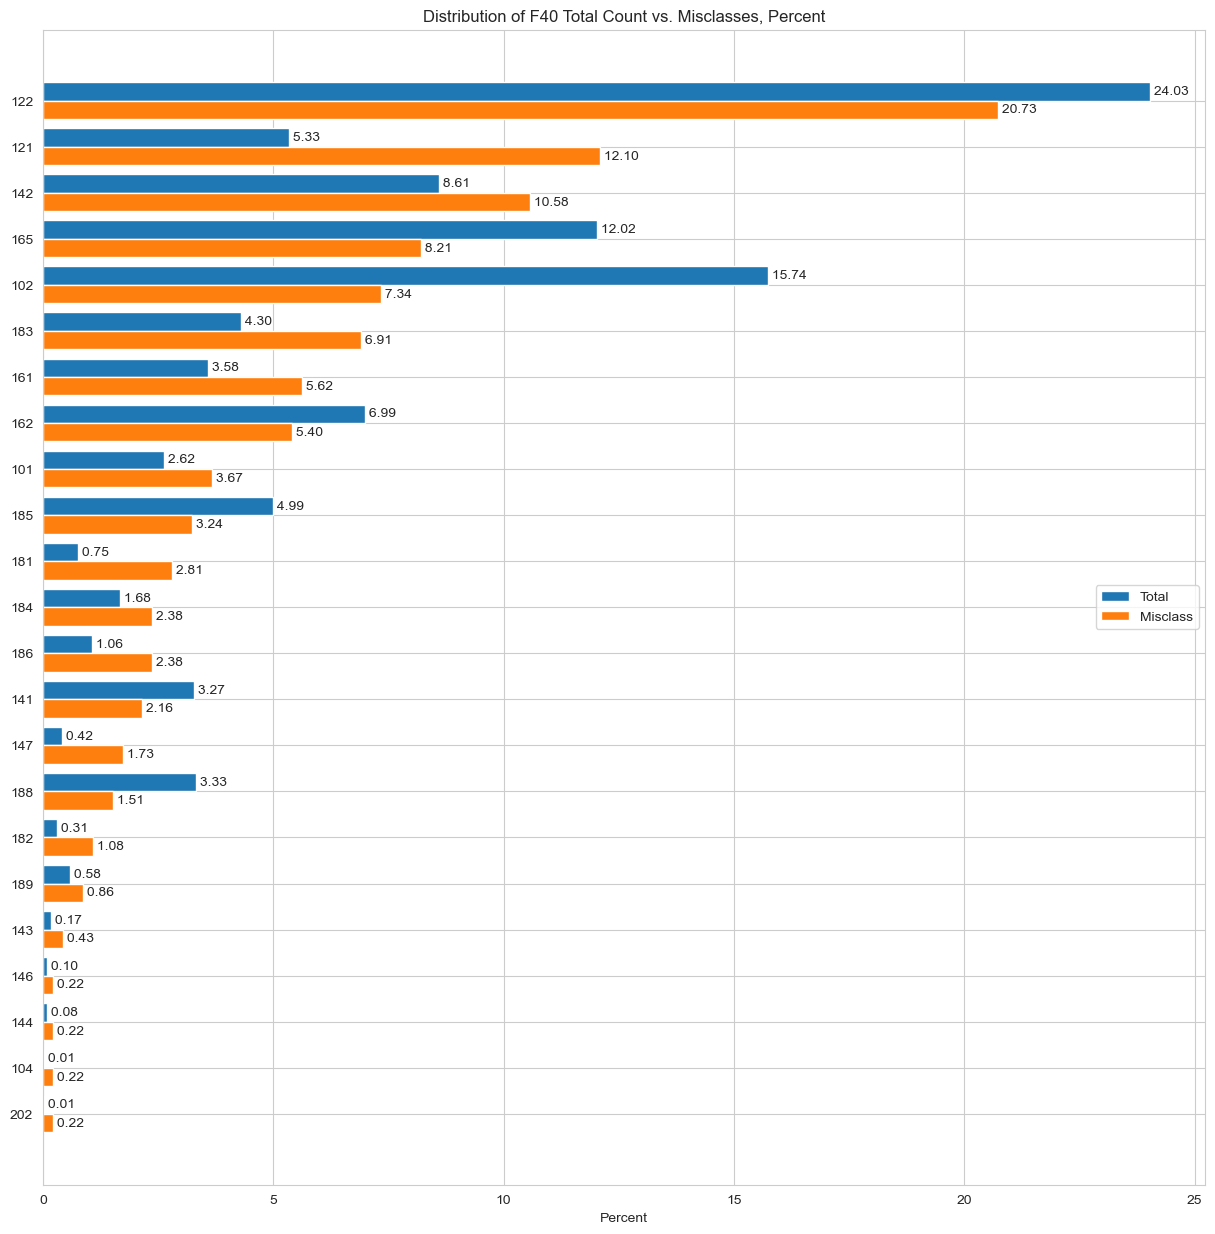

In [103]:
# Get dataframe of misclassed F40s
misclass = predictions.loc[predictions['LF22_F40'] != predictions['PRED_LF22_F40']]

# Get dataframe of predictions 
total = predictions.loc[predictions['LF22_F40'].isin(misclass['LF22_F40'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Percent'
title = f'Distribution of F40 Total Count vs. Misclasses, {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='LF22_F40', metric=metric, title=title, figsize=(15, 15))

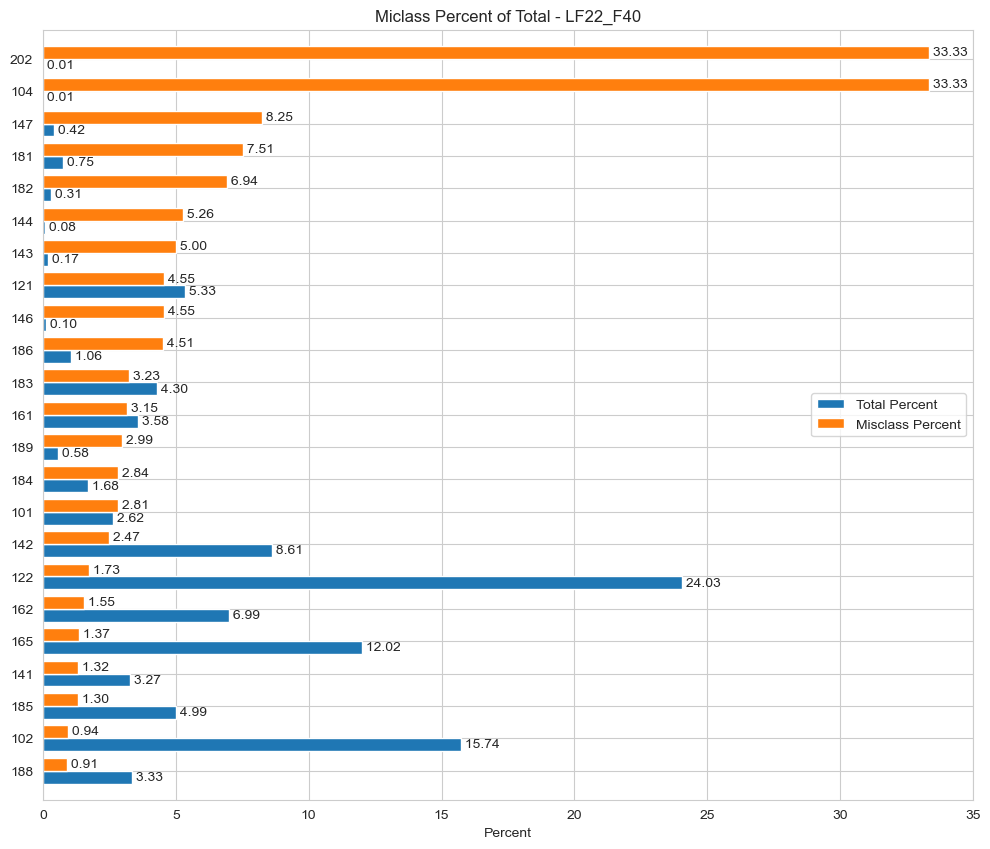

In [104]:
# Subset to misclassified observations
misclass = predictions.loc[~(predictions['LF22_F40'] == predictions['PRED_LF22_F40'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = predictions.loc[predictions['LF22_F40'].isin(misclass['LF22_F40'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Percent'
title = "Miclass Percent of Total - LF22_F40"
plot_percent_total(df_dict=df_dict, group_var='LF22_F40', metric=metric, title=title, figsize=(12, 10))

## __Misclassifications based on FDST__

Are there certain FDST categories that are more commonly misclassified?  

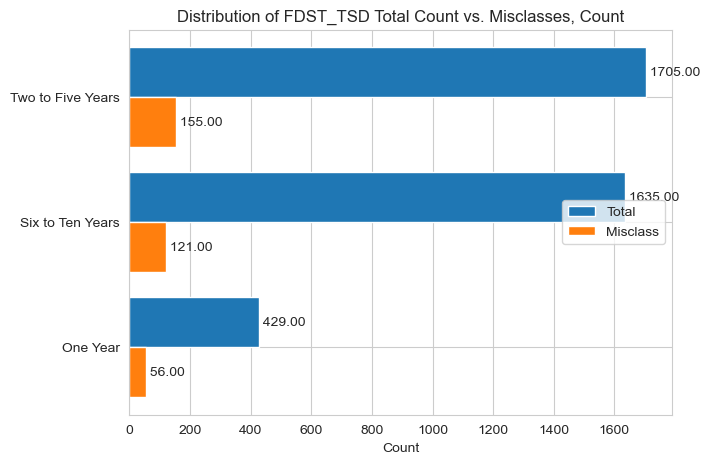

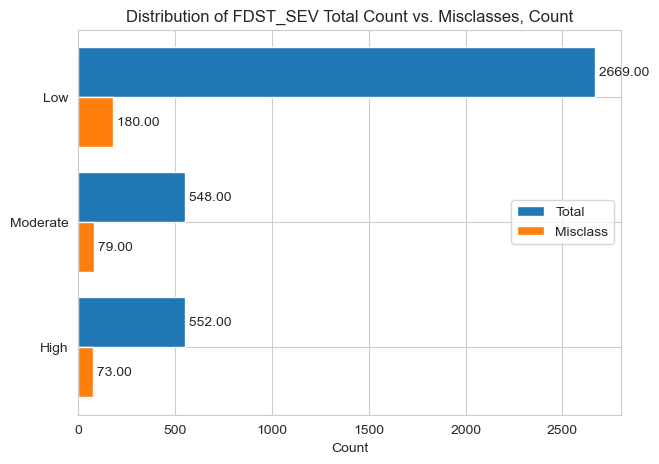

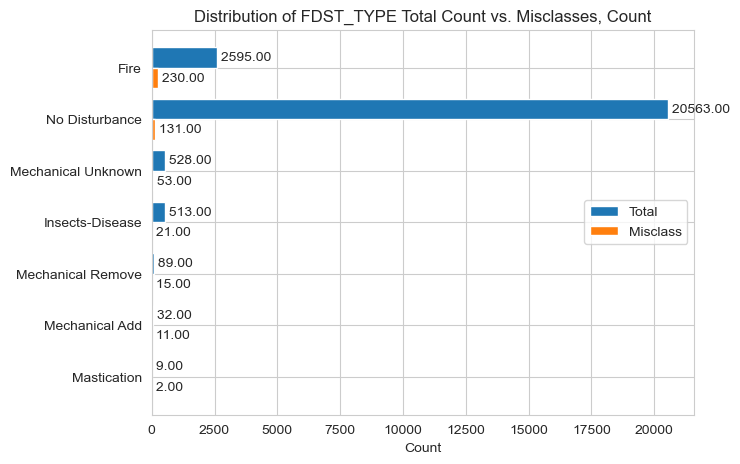

In [105]:
# Get misclasses
misclass = predictions.loc[~(predictions['LF22_F40'] == predictions['PRED_LF22_F40'])]

# Define what plots to generate
group_vars = ['FDST_TSD' ,'FDST_SEV', 'FDST_TYPE']

# Generate plots
metric = 'Count'
df_dict = {'total' : predictions,
           'misclass' : misclass}


for group_var in group_vars:
    title = f'Distribution of {group_var} Total Count vs. Misclasses, {metric}'
    plot_comparison_distribution(df_dict=df_dict, group_var=group_var, metric=metric, title=title, figsize=(7, 5))

# __F40 Predicted Raster Evaluation__
Perform the above assessment using the raster generated with the F40 model. 

-----

In [54]:
# Read in data 
raster_fpaths_dict = {
    "Predictions" : paths_dict['pred_F40_raster'],
    "Original" : paths_dict['og_F40_raster'] 
    }

data_dict = {}
for var, item in raster_fpaths_dict.items():
    with rasterio.open(item) as src:
        data = src.read()
        data_dict[var] = data.ravel()

# Create dataframe from dictionary of predictions/original
df = pd.DataFrame(data_dict)
df.head()

,Predictions,Original
0,32767,32767
1,32767,32767
2,32767,32767
3,32767,32767
4,32767,32767


In [55]:
# Process the data
# Remove observations with -9999/-1111 in any field 
matches = df[(df.isin([-1111, -9999])).any(axis=1)]  # Find rows with -1111/-9999 in any column
df = df.drop(matches.index, axis=0)  # Drop those rows

# Remove Non-Burnable Classes
F40_NB = [91, 92, 93, 98, 99]  # Nonburnable F40 Classes
df = df.loc[~df['Original'].isin(F40_NB)]  # Drop NB classes

In [ ]:
# Get results
results_dict = {
  "accuracy" : accuracy_score(df['Original'], df['Predictions']),
  "recall" : recall_score(df['Original'], df['Predictions'], average='macro'),
  "precision" : precision_score(df['Original'], df['Predictions'], average='macro')
}

results = pd.DataFrame([results_dict])
print(results)


In [35]:
# Save out results
results_dict.to_csv(os.path.join(paths_dict['results_out_dir'], paths_dict['results_out_fname']))

,accuracy,recall,precision
0,0.228481,0.033606,0.037568
